In [1]:
from functools import partial
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import time
from IPython import display
%matplotlib inline

from jax.config import config
config.update("jax_debug_nans", True)

# Learning manipulation

This notebook implements a number of toy problems from manipulation in a differentiable simulator, then applies both gradient descent (with access to simulator gradients) and vanilla policy gradient (without access) to compare the learning performance of these methods.

## Tasks

We'll implement three tasks of increasing difficulty, all in a 2D setting.

### Task 1: box pivoting

Given a point robot (driven using stiffness control, with desired $x$ and $y$ position as control inputs) and an unactuated block, but this time in the x-z plane, pivot the block into a desired pose.

### Task 2: box grasping

Now represent the robot as two points, with stiffness control on the central point of the gripper, orientation, and distance between the fingers. The goal now is to pick up an unactuated block and move it to a desired pose in mid-air.

## Implementation

Let's start by implementing a utility function for getting the signed distance between a point finger and a box

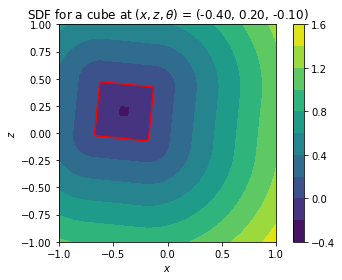

In [2]:
@jax.jit
def box_finger_signed_distance(box_pose, finger_pose, box_size):
    """Compute the signed distance from the box to the finger
    
    args:
        box_pose: current (x, z, theta) state of the box
        finger_pose: current (x, z) state of the finger
        box_size: side length of box
    returns:
        float signed distance
    """
    # Credit to this stackoverflow answer for the inspiration for this code:
    # stackoverflow.com/questions/30545052/calculate-signed-distance-between-point-and-rectangle
    
    # First transform the finger (x, z) into the box frame
    p_WF = finger_pose
    p_WB = box_pose[:2]
    theta_B = box_pose[2]
    
    p_BF_W = p_WF - p_WB
    # Rotate p_BF_W by -theta about the z axis to get position in box frame
    R_WB = jnp.array([[jnp.cos(theta_B), -jnp.sin(theta_B)], [jnp.sin(theta_B), jnp.cos(theta_B)]])
    R_BW = R_WB.T
    p_BF = R_BW @ p_BF_W
    
    # Now get the signed distance
    x_dist = jnp.maximum(-(p_BF[0] + box_size / 2.0), p_BF[0] - box_size / 2.0)
    z_dist = jnp.maximum(-(p_BF[1] + box_size / 2.0), p_BF[1] - box_size / 2.0)
    
    # phi = signed distance. 
    phi = jnp.minimum(0.0, jnp.maximum(x_dist, z_dist))
    phi = phi + jnp.linalg.norm(jnp.maximum(jnp.array([1e-3, 1e-3]), jnp.array([x_dist, z_dist])))
    
    return phi

# Test it out
box_pose = jnp.array([-0.4, 0.2, -0.1])
box_size = 0.5

finger_x = jnp.linspace(-1, 1, 100)
finger_z = jnp.linspace(-1, 1, 100)

finger_X, finger_Z = jnp.meshgrid(finger_x, finger_z)
finger_XZ = jnp.stack((finger_X, finger_Z)).reshape(2, 10000).T

f_phi = lambda xz: box_finger_signed_distance(box_pose, xz, box_size)
Phi = jax.vmap(f_phi, in_axes=0)(finger_XZ).reshape(100, 100)
fig, ax = plt.subplots()
contours = ax.contourf(finger_X, finger_Z, Phi, levels=10)
zero_contour = ax.contour(finger_X, finger_Z, Phi, levels=[0], colors="r")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$z$")
ax.set_title(r"SDF for a cube at $(x, z, \theta)$ = "
             + "({:.2f}, {:.2f}, {:.2f})".format(box_pose[0], box_pose[1], box_pose[2]))
ax.set_aspect("equal")
_ = fig.colorbar(contours)

Let's start with the single step update function and then wrap that in a simulator.

In [3]:
@jax.jit
def rotation_matrix(theta):
    """Return the 2D rotation matrix for angle theta"""
    return jnp.array([
        [jnp.cos(theta), -jnp.sin(theta)],
        [jnp.sin(theta), jnp.cos(theta)]
    ])

@jax.jit
def calc_finger_ground_force(finger_state, mu_d, c, psi_s, contact_k, contact_d):
    """Compute the contact force between a finger and the ground.
    
    args:
        finger_state: current (x, z, theta, vx, vz, omega) state of the box
        mu_d: coefficient of friction between box and ground while slipping
        c: coefficient of tangential velocity in determining sticking friction
        psi_s: tangential velocity where slipping begins
        contact_k: spring constant of contact
        contact_d: damping constant of contact
    returns:
        contact force in x and z
    """
    # Get the position and velocity of the finger in the world frame
    p_WF = finger_state[:2]
    v_WF = finger_state[2:]

    # Get penetration into ground
    phi_finger_ground = jnp.minimum(jnp.zeros(1), p_WF[1])
    
    # Get the contact forces. Approximate ground force as a damped spring, as in
    # the simplified friction model from eq 21 and 22 in
    # https://arxiv.org/pdf/2109.05143.pdf, but with damping.
    normal_velocity = v_WF[1]
    normal_force = -contact_k * phi_finger_ground
    normal_force = normal_force - contact_d * normal_velocity * (phi_finger_ground < 0)
    tangential_velocity = v_WF[0]
    sticking_mask = jnp.abs(tangential_velocity) <= psi_s
    slipping_mask = jnp.logical_not(sticking_mask) * jnp.sign(tangential_velocity)
    mu = sticking_mask * c * tangential_velocity + slipping_mask * mu_d
    tangent_force = -mu * normal_force

    contact_force = jnp.array([tangent_force, normal_force]).reshape(2)

    return contact_force

@jax.jit
def calc_box_ground_wrench(box_state, box_size, mu_d, c, psi_s, contact_k, contact_d):
    """Compute the contact wrench between the box and the ground.
    
    args:
        box_state: current (x, z, theta, vx, vz, omega) state of the box
        box_size: float indicating the side length of the box
        mu_d: coefficient of friction between box and ground while slipping
        c: coefficient of tangential velocity in determining sticking friction
        psi_s: tangential velocity where slipping begins
        contact_k: spring constant of contact
        contact_d: damping constant of contact
    returns:
        contact wrench in x, z, and theta.
    """
    # Start by finding any box corner points that intersect the ground at z = 0
    half_size = box_size / 2.0
    p_BC = jnp.array([
        [-half_size, half_size],  # top left
        [half_size, half_size],  # top right
        [-half_size, -half_size],  # bottom left
        [half_size, -half_size],  # bottom right
    ])  # corner points in box frame
    # Transform into world frame
    R_WB = rotation_matrix(box_state[2])
    p_BC_W = (R_WB @ p_BC.T).T
    p_WC = p_BC_W + jnp.tile(box_state[:2], [4, 1])
    
    # Also find the velocities of each corner point
    r = jnp.sqrt(2) * half_size
    v_BC = box_state[5] * r * jnp.array([
        [-1, -1],  # top left
        [-1, 1],  # top right
        [1, -1],  # bottom left
        [1, 1],  # bottom right
    ])  # corner point velocities in box frame
    # Transform to world frame
    v_WC = (R_WB @ v_BC.T).T + jnp.tile(box_state[3:5], [4, 1])
    
    # Find any that have negative z: min(0, signed distance)
    phi_corner_ground = jnp.minimum(jnp.zeros(4), p_WC[:, 1])
    
    # For each corner, sum up the forces and torques due to penetration with the ground
    contact_wrench_on_box = jnp.zeros(3)
    for i in range(4):
        # Get the friction force. Approximate ground force as a damped spring, as in
        # the simplified friction model from eq 21 and 22 in
        # https://arxiv.org/pdf/2109.05143.pdf, but with damping.
        normal_velocity = v_WC[i, 1]
        normal_force = -contact_k * phi_corner_ground[i]
        normal_force = normal_force - contact_d * normal_velocity * (phi_corner_ground[i] < 0)
        tangential_velocity = v_WC[i, 0]
        sticking_mask = jnp.abs(tangential_velocity) <= psi_s
        slipping_mask = jnp.logical_not(sticking_mask) * jnp.sign(tangential_velocity)
        mu = sticking_mask * c * tangential_velocity + slipping_mask * mu_d
        tangent_force = -mu * normal_force
        
        contact_force = jnp.array([tangent_force, normal_force])
        
        # Add the friction force to the box
        contact_wrench_on_box = contact_wrench_on_box.at[:2].add(contact_force)
        
        # Also add the torque from this interaction
        contact_wrench_on_box = contact_wrench_on_box.at[2].add(jnp.cross(p_BC_W[i, :], contact_force))
    
    return contact_wrench_on_box


@jax.jit
def calc_box_finger_wrench(box_state, finger_state, box_size, mu_d, c, psi_s, contact_k, contact_d):
    """Compute the contact wrench between the box and the ground.
    
    args:
        box_state: current (x, z, theta, vx, vz, omega) state of the box
        finger_state: current (x, z, vx, vz) state of the finger
        box_size: float indicating the side length of the box
        mu_d: coefficient of friction between box and ground while slipping
        c: coefficient of tangential velocity in determining sticking friction
        psi_s: tangential velocity where slipping begins
        contact_k: spring constant of contact
        contact_d: damping constant of contact
    returns:
        Tuple of
            - contact wrench on box in x, z, and theta.
            - contact force on finger in x and z.
    """
    # Contact point is just the finger point in the box frame
    p_WF = finger_state[:2]
    p_WB = box_state[:2]
    p_BF_W = p_WF - p_WB
    R_WB = rotation_matrix(box_state[2])
    p_BF = R_WB.T @ p_BF_W
    
    # Get velocity of the finger in box frame
    v_WF = finger_state[2:]
    v_WB = box_state[3:5]
    v_BF_W = v_WF - v_WB
    v_BF = R_WB.T @ v_BF_W
    
    # Get velocity of contact point in box frame
    v_Bcontact = box_state[5] * jnp.array([[0, -1], [1, 0]]) @ p_BF
    
    # Get velocity of finger relative to contact pt in box frame
    v_contactF_B = v_BF - v_Bcontact

    # Get the normal vector of the contact in the box frame
    right_or_up = p_BF[1] > -p_BF[0]
    left_or_up = p_BF[1] > p_BF[0]
    normal_right = jnp.logical_and(right_or_up, jnp.logical_not(left_or_up))
    normal_up = jnp.logical_and(right_or_up, left_or_up)
    normal_left = jnp.logical_and(jnp.logical_not(right_or_up), left_or_up)
    normal_down = jnp.logical_and(jnp.logical_not(right_or_up), jnp.logical_not(left_or_up))
    normal = normal_right * jnp.array([1.0, 0.0])
    normal += normal_left * jnp.array([-1.0, 0.0])
    normal += normal_up * jnp.array([0.0, 1.0])
    normal += normal_down * jnp.array([0.0, -1.0])
    
    # Get the tangent vector, which is orthogonal to the normal vector
    # and points in the same direction as the relative velocity
    tangential_velocity = v_contactF_B - v_contactF_B.dot(normal) * normal  # relative velocity in tangent direction
    normal_velocity = v_contactF_B.dot(normal)  # scalar, along the normal vector
    tangent = tangential_velocity / (jnp.linalg.norm(tangential_velocity + 1e-3) + 1e-3)
    
    # Get signed distance
    phi_finger_box = box_finger_signed_distance(box_state[:3], finger_state[:2], box_size)
    # Clip to only consider negative values
    phi_finger_box = jnp.minimum(0, phi_finger_box)
        
    # Use the same simplified friction model as used for ground contact
    normal_force = -contact_k * phi_finger_box  # scalar, in normal direction
    normal_force = normal_force - contact_d * normal_velocity * (phi_finger_box < 0)
    sticking_mask = jnp.linalg.norm(tangential_velocity + 1e-3) <= psi_s
    slipping_mask = jnp.logical_not(sticking_mask)
    mu = sticking_mask * c * tangential_velocity + slipping_mask * mu_d * tangent
    tangent_force = -mu * normal_force  # vector!
    
    # Sum up the contact forces in the box frame
    contact_force_B = normal_force * normal + tangent_force
    # transform into the world frame
    contact_force_W = R_WB @ contact_force_B
    
    # Add the contact force to the box and finger
    box_wrench = jnp.zeros(3)
    box_wrench = box_wrench.at[:2].add(-contact_force_W)
    box_wrench = box_wrench.at[2].add(jnp.cross(p_BF_W, -contact_force_W))
    
    finger_forces = contact_force_W
    
    return box_wrench, finger_forces


@jax.jit
def box_single_finger_step(
    box_state,
    finger_state,
    finger_state_desired,
    finger_control_stiffness,
):
    """Compute a single discrete-time update for box manipulation with one finger, using the penalty method
    for contact modelling with a simplified Coulomb friction model
    
    args:
        box_state: current (x, z, theta, vx, vz, omega) state of the box
        finger_state: current (x, z, vx, vz) state of the finger
        finger_state_desired: desired (x_d, z_d) state of the finger
        finger_control_stiffness: the parameter for the finger stiffness control
    returns:
        new_box_state, new_finger_state
    """
    ######################################
    # define parameters of the simulation
    ######################################
    # Box properties
    box_mass_kg = 1.0
    box_side_m = 0.5
    box_inertia = 1/6 * box_mass_kg * box_side_m ** 2
    
    # Finger properties
    finger_mass_kg = 0.1
    finger_control_damping = 2
    
    # Contact properties
    mu_d = 0.7
    c = 2.0
    psi_s = mu_d / c
    contact_k = 1000
    contact_d = 2 * jnp.sqrt(box_mass_kg * contact_k)  # critical damping
    
    # General properties
    g = 9.81
    dt = 0.001  # seconds per step
    
    ######################################
    # Get forces on each body
    ######################################
    finger_forces = jnp.zeros(2)
    box_forces = jnp.zeros(3)
    
    # Gravitational force on each body
    finger_forces = finger_forces.at[1].add(-g * finger_mass_kg)
    box_forces = box_forces.at[1].add(-g * box_mass_kg)
    
    # Control forces on finger
    finger_pos_error = finger_state_desired - finger_state[:2]
    finger_vel_error = -finger_state[2:]
    finger_forces = finger_forces + finger_control_stiffness * finger_pos_error
    finger_forces = finger_forces + finger_control_damping * finger_vel_error
    
    # Contact forces from the ground.
    box_forces += calc_box_ground_wrench(box_state, box_size, mu_d, c, psi_s, contact_k, contact_d)
    finger_forces += calc_finger_ground_force(finger_state, mu_d, c, psi_s, contact_k, contact_d)
    
    # Contact forces between box and finger
    finger_wrench_on_box, box_force_on_finger = calc_box_finger_wrench(
        box_state,
        finger_state,
        box_size,
        mu_d,
        c,
        psi_s,
        contact_k,
        contact_d
    )
    box_forces += finger_wrench_on_box
    finger_forces += box_force_on_finger
    
    ######################################
    # Numerically integrate
    ######################################
    # Build the derivatives matrix
    box_state_dot = jnp.zeros(6)
    finger_state_dot = jnp.zeros(4)
    
    # Velocities
    box_state_dot = box_state_dot.at[:3].add(box_state[3:])
    finger_state_dot = finger_state_dot.at[:2].add(finger_state[2:])
    
    # Forces
    box_state_dot = box_state_dot.at[3:5].add(box_forces[:2] / box_mass_kg)
    finger_state_dot = finger_state_dot.at[2:].add(finger_forces / finger_mass_kg)
    
    # Torques
    box_state_dot = box_state_dot.at[5].add(box_forces[2] / box_inertia)
    
    # Itegrate
    new_box_state = box_state + dt * box_state_dot
    new_finger_state = finger_state + dt * finger_state_dot
    
    return new_box_state, new_finger_state


def box_single_finger_simulate(
    box_state_initial,
    finger_state_initial,
    finger_state_desired_trace,
    finger_control_stiffness,
    N_steps,
):
    """Simulate the evolution of the box-finger system with one finger, starting at the given initial states
    and applying the specified control inputs
    
    args:
        box_state_initial: initial (x, z, theta, vx, vz, omega) state of the box
        finger_state_initial: initial (x, z, vx, vz) state of the finger
        finger_state_desired_trace: N_steps x 2 array of desired (x_d, z_d) state of the finger over time
        finger_control_stiffness: the parameter for the finger stiffness control
        N_steps: int specifying the number of discrete time steps to simulate
    returns:
        box_state_trace, finger_state_trace
    """
    # Create arrays to store simulation traces
    box_state_trace = jnp.zeros((N_steps, 6))
    finger_state_trace = jnp.zeros((N_steps, 4))
    
    # Store the initial conditions
    box_state_trace = box_state_trace.at[0, :].set(box_state_initial)
    finger_state_trace = finger_state_trace.at[0, :].set(finger_state_initial)
    
    # Simulate
    for i in range(1, N_steps):
        # get currents state
        current_box_state = box_state_trace[i - 1, :]
        current_finger_state = finger_state_trace[i - 1, :]
        current_finger_state_desired = finger_state_desired_trace[i - 1]
        
        # get next state
        next_box_state, next_finger_state = box_single_finger_step(
            current_box_state,
            current_finger_state,
            current_finger_state_desired,
            finger_control_stiffness,
        )
        
        # Save
        box_state_trace = box_state_trace.at[i, :].set(next_box_state)
        finger_state_trace = finger_state_trace.at[i, :].set(next_finger_state)
    
    # Return the simulated values
    return box_state_trace, finger_state_trace

@jax.jit
def box_two_finger_step(
    box_state,
    finger1_state,
    finger1_state_desired,
    finger2_state,
    finger2_state_desired,
    finger_control_stiffness,
):
    """Compute a single discrete-time update for box manipulation with one finger, using the penalty method
    for contact modelling with a simplified Coulomb friction model
    
    args:
        box_state: current (x, z, theta, vx, vz, omega) state of the box
        finger1_state: current (x, z, vx, vz) state of the first finger
        finger1_state_desired: desired (x_d, z_d) state of the first finger
        finger2_state: current (x, z, vx, vz) state of the second finger
        finger2_state_desired: desired (x_d, z_d) state of the second finger
        finger_control_stiffness: the parameter for the finger stiffness control
    returns:
        new_box_state, new_finger_state
    """
    ######################################
    # define parameters of the simulation
    ######################################
    # Box properties
    box_mass_kg = 1.0
    box_side_m = 0.5
    box_inertia = 1/6 * box_mass_kg * box_side_m ** 2
    
    # Finger properties
    finger_mass_kg = 0.1
    finger_control_damping = 2
    
    # Contact properties
    mu_d = 0.7
    c = 2.0
    psi_s = mu_d / c
    contact_k = 1000
    contact_d = 2 * jnp.sqrt(box_mass_kg * contact_k)  # critical damping
    
    # General properties
    g = 9.81
    dt = 0.001  # seconds per step
    
    ######################################
    # Get forces on each body
    ######################################
    finger1_forces = jnp.zeros(2)
    finger2_forces = jnp.zeros(2)
    box_forces = jnp.zeros(3)
    
    # Gravitational force on each body
    finger1_forces = finger1_forces.at[1].add(-g * finger_mass_kg)
    finger2_forces = finger2_forces.at[1].add(-g * finger_mass_kg)
    box_forces = box_forces.at[1].add(-g * box_mass_kg)
    
    # Control forces on fingers
    finger1_pos_error = finger1_state_desired - finger1_state[:2]
    finger1_vel_error = -finger1_state[2:]
    finger1_forces = finger1_forces + finger_control_stiffness * finger1_pos_error
    finger1_forces = finger1_forces + finger_control_damping * finger1_vel_error
    
    finger2_pos_error = finger2_state_desired - finger2_state[:2]
    finger2_vel_error = -finger2_state[2:]
    finger2_forces = finger2_forces + finger_control_stiffness * finger2_pos_error
    finger2_forces = finger2_forces + finger_control_damping * finger2_vel_error
    
    # Contact forces from ground.
    box_forces += calc_box_ground_wrench(box_state, box_size, mu_d, c, psi_s, contact_k, contact_d)
    finger1_forces += calc_finger_ground_force(finger1_state, mu_d, c, psi_s, contact_k, contact_d)
    finger2_forces += calc_finger_ground_force(finger2_state, mu_d, c, psi_s, contact_k, contact_d)
    
    # Contact forces between box and fingers
    finger1_wrench_on_box, box_force_on_finger1 = calc_box_finger_wrench(
        box_state,
        finger1_state,
        box_size,
        mu_d,
        c,
        psi_s,
        contact_k,
        contact_d
    )
    box_forces += finger1_wrench_on_box
    finger1_forces += box_force_on_finger1
    
    finger2_wrench_on_box, box_force_on_finger2 = calc_box_finger_wrench(
        box_state,
        finger2_state,
        box_size,
        mu_d,
        c,
        psi_s,
        contact_k,
        contact_d
    )
    box_forces += finger2_wrench_on_box
    finger2_forces += box_force_on_finger2
    
    ######################################
    # Numerically integrate
    ######################################
    # Build the derivatives matrix
    box_state_dot = jnp.zeros(6)
    finger1_state_dot = jnp.zeros(4)
    finger2_state_dot = jnp.zeros(4)
    
    # Velocities
    box_state_dot = box_state_dot.at[:3].add(box_state[3:])
    finger1_state_dot = finger1_state_dot.at[:2].add(finger1_state[2:])
    finger2_state_dot = finger2_state_dot.at[:2].add(finger2_state[2:])
    
    # Forces
    box_state_dot = box_state_dot.at[3:5].add(box_forces[:2] / box_mass_kg)
    finger1_state_dot = finger1_state_dot.at[2:].add(finger1_forces / finger_mass_kg)
    finger2_state_dot = finger2_state_dot.at[2:].add(finger2_forces / finger_mass_kg)
    
    # Torques
    box_state_dot = box_state_dot.at[5].add(box_forces[2] / box_inertia)
    
    # Itegrate
    new_box_state = box_state + dt * box_state_dot
    new_finger1_state = finger1_state + dt * finger1_state_dot
    new_finger2_state = finger2_state + dt * finger2_state_dot
    
    return new_box_state, new_finger1_state, new_finger2_state


def box_two_finger_simulate(
    box_state_initial,
    finger1_state_initial,
    finger1_state_desired_trace,
    finger2_state_initial,
    finger2_state_desired_trace,
    finger_control_stiffness,
    N_steps,
):
    """Simulate the evolution of the box-finger system with one finger, starting at the given initial states
    and applying the specified control inputs
    
    args:
        box_state_initial: initial (x, z, theta, vx, vz, omega) state of the box
        finger1_state_initial: initial (x, z, vx, vz) state of the finger
        finger1_state_desired_trace: N_steps x 2 array of desired (x_d, z_d) state of the finger over time
        finger2_state_initial: initial (x, z, vx, vz) state of the finger
        finger2_state_desired_trace: N_steps x 2 array of desired (x_d, z_d) state of the finger over time
        finger_control_stiffness: the parameter for the finger stiffness control
        N_steps: int specifying the number of discrete time steps to simulate
    returns:
        box_state_trace, finger_state_trace
    """
    # Create arrays to store simulation traces
    box_state_trace = jnp.zeros((N_steps, 6))
    finger1_state_trace = jnp.zeros((N_steps, 4))
    finger2_state_trace = jnp.zeros((N_steps, 4))
    
    # Store the initial conditions
    box_state_trace = box_state_trace.at[0, :].set(box_state_initial)
    finger1_state_trace = finger1_state_trace.at[0, :].set(finger1_state_initial)
    finger2_state_trace = finger2_state_trace.at[0, :].set(finger2_state_initial)
    
    # Simulate
    for i in range(1, N_steps):
        # get currents state
        current_box_state = box_state_trace[i - 1, :]
        current_finger1_state = finger1_state_trace[i - 1, :]
        current_finger1_state_desired = finger1_state_desired_trace[i - 1]
        current_finger2_state = finger2_state_trace[i - 1, :]
        current_finger2_state_desired = finger2_state_desired_trace[i - 1]
        
        # get next state
        next_box_state, next_finger1_state, next_finger2_state = box_two_finger_step(
            current_box_state,
            current_finger1_state,
            current_finger1_state_desired,
            current_finger2_state,
            current_finger2_state_desired,
            finger_control_stiffness,
        )
        
        # Save
        box_state_trace = box_state_trace.at[i, :].set(next_box_state)
        finger1_state_trace = finger1_state_trace.at[i, :].set(next_finger1_state)
        finger2_state_trace = finger2_state_trace.at[i, :].set(next_finger2_state)
    
    # Return the simulated values
    return box_state_trace, finger1_state_trace, finger2_state_trace

Let's run some tests!

In [4]:
def make_box_patches(box_state, alpha, box_side_length, ax):
    """Adds patches for visualizing the box to the given axes
    
    args:
        box_state: (x, z, theta, vx, vz, thetadot)
        alpha: float transparency
        box_side_length: float side length of box
        ax: matplotlib axes
    returns:
        a list of properly transformed and colored patches for the box
    """
    box_xz = box_state[:2]
    box_theta = box_state[2]
    xform = transforms.Affine2D()
    xform = xform.rotate_around(box_side_length / 2.0, box_side_length / 2.0, theta=box_theta)
    xform = xform.translate(*(box_xz - box_side_length / 2.0))
    xform = xform + ax.transData
    box = patches.Rectangle(
        (0, 0),
        box_side_length,
        box_side_length,
        linewidth=2,
        transform=xform,
        edgecolor=plt.get_cmap("Blues")(0.1 + alpha),
        fill=False,
    )
    ax.add_patch(box)
    
    # Add an arrow pointing up
    xform = transforms.Affine2D()
    xform = xform.rotate_around(box_side_length / 2.0, box_side_length / 2.0, theta=box_theta)
    xform = xform.translate(*(box_xz - box_side_length / 2.0))
    xform = xform + ax.transData
    arrow = patches.Arrow(
        0,
        0,
        0,
        box_side_length / 8,
        width=box_side_length / 20,
        linewidth=2,
        transform=xform,
        edgecolor=plt.get_cmap("Blues")(0.1 + alpha),
        fill=True,
    )
    ax.add_patch(arrow)
    
    
def make_finger_patches(finger_state, alpha, ax):
    """Adds patches for visualizing the finger to the given axes
    
    args:
        box_state: (x, z, theta, vx, vz, thetadot)
        alpha: float transparency
        box_side_length: float side length of box
        ax: matplotlib axes
    returns:
        a list of properly transformed and colored patches for the box
    """
    finger_xz = finger_state[:2]
    xform = transforms.Affine2D()
    xform = xform.translate(*finger_xz)
    xform = xform + ax.transData
    finger = patches.Circle(
        (0, 0),
        0.005,
        linewidth=2,
        transform=xform,
        edgecolor=plt.get_cmap("Oranges")(0.1 + alpha),
        facecolor=plt.get_cmap("Oranges")(0.1 + alpha),
        fill=True,
    )
    ax.add_patch(finger)

Simulation complete in 5.056 s


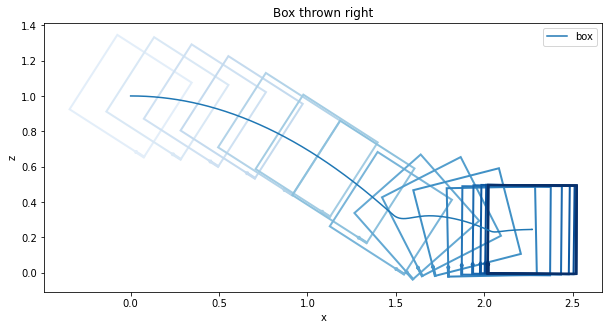

In [5]:
# Starting from a little above the ground, drop the box without touching it.
# At the same time, test the response of the finger stiffness control.
# abbreviate bs = box_state, fs = finger_state
bs_initial = jnp.array([0.0, 1.0, 1.0, 4.0, 0.0, 0.0])
fs_initial = jnp.array([0.0, 0.0, 0.0, 0.0])
finger_k = 10
N_steps = 1000
fs_desired_trace = jnp.zeros((N_steps, 2))

# Simulate
start = time.time()
bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
end = time.time()
print(f"Simulation complete in {round(end - start, 3)} s")

# Make the plots
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the center of mass trajectory
ax.plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
# ax.plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, ax)

# Label etc.
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_aspect("equal")
ax.set_title("Box thrown right")
_ = ax.legend()

Simulation complete in 4.136 s


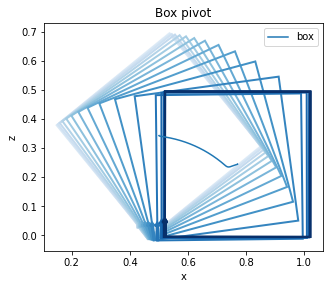

In [6]:
# Starting balanced on an edge, fall to the side.
# abbreviate bs = box_state, fs = finger_state
bs_initial = jnp.array([0.5, jnp.sqrt(2) * 0.25 - 1e-2, jnp.pi/4 - 0.1, 0.0, 0.0, 0.0])
fs_initial = jnp.array([0.0, 0.0, 0.0, 0.0])
finger_k = 10
N_steps = 1000
fs_desired_trace = jnp.zeros((N_steps, 2))

# Simulate
start = time.time()
bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
end = time.time()
print(f"Simulation complete in {round(end - start, 3)} s")

# Make the plots
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the center of mass trajectory
ax.plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
# ax.plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, ax)

# Label etc.
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_aspect("equal")
ax.set_title("Box pivot")
_ = ax.legend()

Simulation complete in 4.398 s


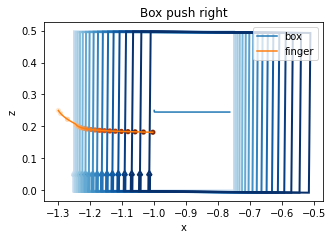

In [7]:
# Start with the box on the ground and push it
# abbreviate bs = box_state, fs = finger_state
bs_initial = jnp.array([-1.0, 0.25, 0.0, 0.0, 0.0, 0.0])
fs_initial = jnp.array([-1.3, 0.25, 0.0, 0.0])
finger_k = 10
N_steps = 1000
fs_desired_trace = jnp.zeros((N_steps, 2))
fs_desired_trace = fs_desired_trace.at[:, 1].add(0.25)
fs_desired_trace = fs_desired_trace.at[:, 0].set(jnp.linspace(-1.25, 0.0, N_steps))

# Simulate
start = time.time()
bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
end = time.time()
print(f"Simulation complete in {round(end - start, 3)} s")

# Make the plots
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the center of mass trajectory
ax.plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
ax.plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, ax)
    make_finger_patches(fs_trace[i], alphas[i].item(), ax)

# Label etc.
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_aspect("equal")
ax.set_title("Box push right")
_ = ax.legend()

Simulation complete in 2.958 s


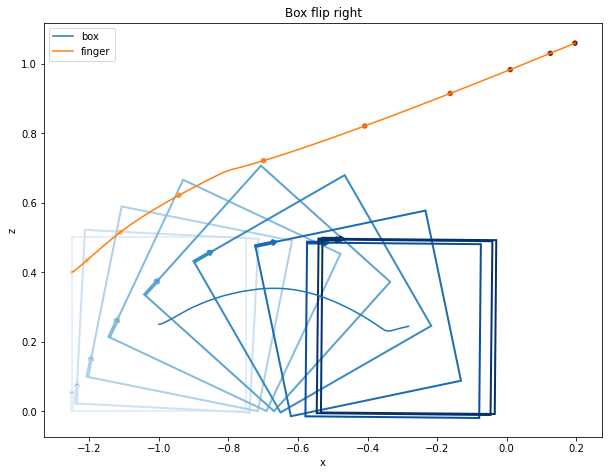

In [8]:
# Start with the box on the ground and flip it
# abbreviate bs = box_state, fs = finger_state
bs_initial = jnp.array([-1.0, 0.25, 0.0, 0.0, 0.0, 0.0])
fs_initial = jnp.array([-1.25, 0.4, 0.0, 0.0])
finger_k = 10
N_steps = 600
fs_desired_trace = jnp.zeros((N_steps, 2))
fs_desired_trace = fs_desired_trace.at[:, 1].set(1.2)
fs_desired_trace = fs_desired_trace.at[:, 0].set(0.3)

# Simulate
start = time.time()
bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
end = time.time()
print(f"Simulation complete in {round(end - start, 3)} s")

# Make the plots
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the center of mass trajectory
ax.plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
ax.plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")

# Plot the box over time
n_steps_to_show = 10
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, ax)
    make_finger_patches(fs_trace[i], alphas[i].item(), ax)

# Label etc.
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_aspect("equal")
ax.set_title("Box flip right")
_ = ax.legend()

Simulation complete in 6.227 s


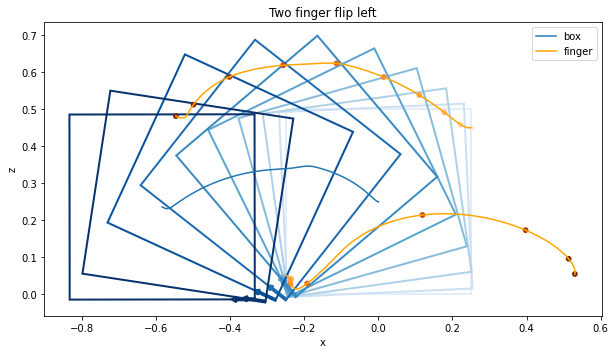

In [9]:
# Start with the box on the ground and flip it, but use two fingers
# abbreviate bs = box_state, fs = finger_state
bs_initial = jnp.array([0.0, 0.25, 0.0, 0.0, 0.0, 0.0])
fs1_initial = jnp.array([-0.25, 0.05, 0.0, 0.0])
fs2_initial = jnp.array([0.25, 0.45, 0.0, 0.0])
finger_k = 20
N_steps = 700
fs1_desired_trace = jnp.zeros((N_steps, 2))
fs1_desired_trace = fs1_desired_trace.at[:, 1].set(0.1)
fs1_desired_trace = fs1_desired_trace.at[:, 0].set(0.5)
fs2_desired_trace = jnp.zeros((N_steps, 2))
fs2_desired_trace = fs2_desired_trace.at[:, 1].set(0.4)
fs2_desired_trace = fs2_desired_trace.at[:, 0].set(-0.5)

# Simulate
start = time.time()
bs_trace, fs1_trace, fs2_trace = box_two_finger_simulate(bs_initial, fs1_initial, fs1_desired_trace, fs2_initial, fs2_desired_trace, finger_k, N_steps)
end = time.time()
print(f"Simulation complete in {round(end - start, 3)} s")

# Make the plots
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the center of mass trajectory
ax.plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
ax.plot(fs1_trace[:, 0], fs1_trace[:, 1], color="orange", label="finger")
ax.plot(fs2_trace[:, 0], fs2_trace[:, 1], color="orange")

# Plot the box over time
n_steps_to_show = 10
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, ax)
    make_finger_patches(fs1_trace[i], alphas[i].item(), ax)
    make_finger_patches(fs2_trace[i], alphas[i].item(), ax)

# Label etc.
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_aspect("equal")
ax.set_title("Two finger flip left")
_ = ax.legend()

# Optimization

Now that we have a simulator, the natural next question is whether we can do some optimization.

## Optimize initial conditions for box toss

Let's start with the simplest possible optimization: find an initial x velocity that causes the box to come to rest in a specific pose.

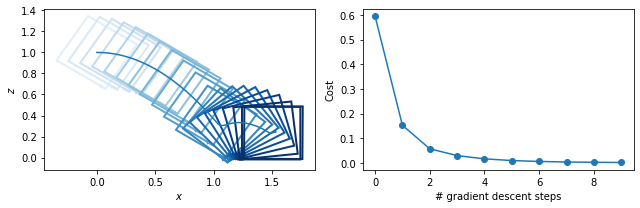

In [10]:
def box_toss_cost(initial_x_velocity):
    """Compute the optimization cost for tossing the box to the right,
    with the goal of landing at x=1.5
    
    args:
        initial_x_velocity: initial velocity in the x direction, m/s
    """
    # Starting from a little above the ground, drop the box without touching it.
    # At the same time, test the response of the finger stiffness control.
    # abbreviate bs = box_state, fs = finger_state
    bs_initial = jnp.array([0.0, 1.0, 1.0, 0.0, 0.0, 0.0])
    fs_initial = jnp.array([0.0, 0.0, 0.0, 0.0])
    finger_k = 10
    N_steps = 1000
    fs_desired_trace = jnp.zeros((N_steps, 2))
    
    # Add the initial x velocity
    bs_initial = bs_initial.at[3].add(initial_x_velocity)

    # Simulate
    bs_trace, _ = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
    
    # Make a cost with a large terminal term
    dt = 1e-3
    x_desired = 1.5
    # cost = 0.1 * dt * jnp.sum((bs_trace[:, 0] - x_desired) ** 2 + 0.1 * bs_trace[:, 3] ** 2)
    # cost = 10 * (bs_trace[-1, 0] - x_desired) ** 2
    cost = (bs_trace[-1, 0] - x_desired) ** 2
    
    return cost

# Optimize the initial velocity, starting from an initial guess
x_velocity_0 = jnp.array(4.0)
x_velocity = x_velocity_0.clone()

# Set up some details for a gradient-descent-based optimization
n_gd_steps = 10
learning_rate = 0.5

# Get the grad function
cost_grad_fn = jax.value_and_grad(box_toss_cost)

# Set up some variables we'll reuse for simulations
bs_initial = jnp.array([0.0, 1.0, 1.0, 0.0, 0.0, 0.0])
fs_initial = jnp.array([0.0, 0.0, 0.0, 0.0])
finger_k = 10
n_sim_steps = 1000
fs_desired_trace = jnp.zeros((N_steps, 2))

# Run gradient descent
costs = []
x_velocity_trace = []
prog_bar = range(n_gd_steps)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
try:
    for i in prog_bar:
        # Get the cost and gradient
        cost, cost_grad = cost_grad_fn(x_velocity)
        
        # Save the cost and velocity
        costs.append(cost)
        x_velocity_trace.append(x_velocity)

        # Plot performance
        bs_initial = bs_initial.at[3].set(x_velocity)
        bs_trace, _ = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)
        plt.close(fig)
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        
        # Plot the center of mass trajectory
        axs[0].plot(bs_trace[:, 0], bs_trace[:, 1], label="box")

        # Plot the box over time
        n_steps_to_show = 20
        i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
        alphas = jnp.linspace(0.0, 1.0, N_steps)
        box_side_length = 0.5
        for i in i_to_show:
            make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, axs[0])
        
        axs[0].set_xlabel(r"$x$")
        axs[0].set_ylabel(r"$z$")
        
        axs[1].plot(costs, "o-")
        axs[1].set_xlabel("# gradient descent steps")
        axs[1].set_ylabel("Cost")
        fig.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)

        # Make the gradient descent step
        x_velocity = x_velocity - learning_rate * cost_grad
except KeyboardInterrupt:
    pass

In [11]:
# Compare before and after optimization
bs_initial = bs_initial.at[3].set(x_velocity_0)
bs_trace_0, _ = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)
bs_initial = bs_initial.at[3].set(x_velocity)
bs_trace, _ = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)

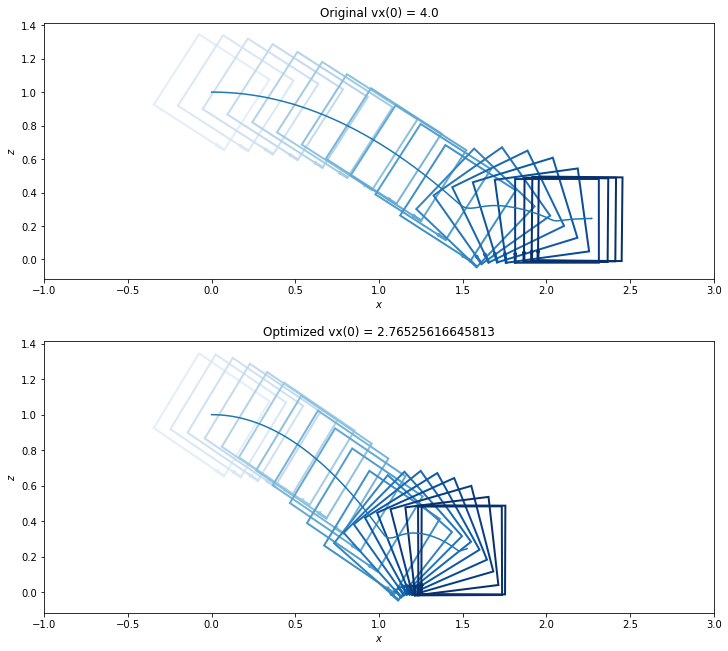

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12, 11))
## Initial
# Plot the center of mass trajectory
axs[0].plot(bs_trace_0[:, 0], bs_trace_0[:, 1], label="box")

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace_0[i], alphas[i].item(), box_side_length, axs[0])

axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$z$")
axs[0].set_title(f"Original vx(0) = {x_velocity_0}")
axs[0].set_xlim([-1.0, 3.0])
axs[0].set_aspect("equal")

## Optimized!
# Plot the center of mass trajectory
axs[1].plot(bs_trace[:, 0], bs_trace[:, 1], label="box")

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, axs[1])

axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$z$")
axs[1].set_title(f"Optimized vx(0) = {x_velocity}")
axs[1].set_xlim([-1.0, 3.0])
axs[0].set_aspect("equal")

That works; great! Let's try a more complicated task

## Optimize single-finger control for box flipping

Let's break the desired finger trajectory into a bunch of piecewise linear bits, then optimize those bits.

This will involve some playing around with initial conditions, since we probably won't be able to converge with initial conditions that don't make contact.

In [13]:
def box_flip_cost(finger_command):
    """Compute the optimization cost for pushing and flipping the box
    
    args:
        finger_command: (x, z) desired finger location 
    """
    bs_initial = jnp.array([-1.0, 0.25, jnp.pi / 2, 0.0, 0.0, 0.0])
    fs_initial = jnp.array([-1.25, 0.4, 0.0, 0.0])
    finger_k = 10
    N_steps = 600
    
    # Set the desired finger location as a first-order hold
    fs_desired_trace = jnp.zeros((N_steps, 2))
    fs_desired_trace = fs_desired_trace.at[:, 0].add(finger_command[0])
    fs_desired_trace = fs_desired_trace.at[:, 1].add(finger_command[1])
    
    # Simulate
    bs_trace, _ = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, N_steps)
    
    # Make a cost using just the terminal values of x and theta
    cost = bs_trace[-1, 0] ** 2 + bs_trace[-1, 2] ** 2
    
    return cost

Since I want to investigate the role of initial conditions, let's try this with a couple of different initializations

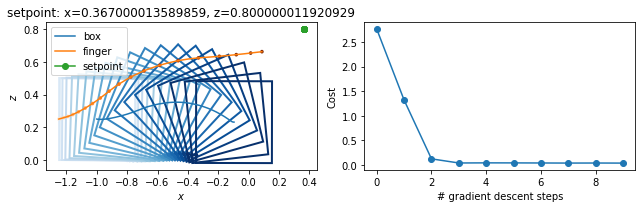

In [14]:
# NOTE: This initialization will just push the box a bit.
waypoints_0 = jnp.array([0.0, 0.25])
waypoints = waypoints_0.clone()

# Set up some details for a gradient-descent-based optimization
n_gd_steps = 10
learning_rate = 1e-1

# Get the grad function
cost_grad_fn = jax.value_and_grad(box_flip_cost)

# Set up some variables we'll reuse for simulations
bs_initial = jnp.array([-1.0, 0.25, jnp.pi / 2, 0.0, 0.0, 0.0])
fs_initial = jnp.array([-1.25, 0.25, 0.0, 0.0])
finger_k = 10
n_sim_steps = 600
fs_desired_trace = jnp.zeros((N_steps, 2))

# Run gradient descent
costs = []
waypoint_trace = []
prog_bar = range(n_gd_steps)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
try:
    for i in prog_bar:
        # Get the cost and gradient
        cost, cost_grad = cost_grad_fn(waypoints)
                
        # Save the cost and velocity
        costs.append(cost)
        waypoint_trace.append(waypoints)

        # Plot performance
        fs_desired_trace = jnp.zeros((N_steps, 2))
        fs_desired_trace = fs_desired_trace.at[:, 0].add(waypoints[0])
        fs_desired_trace = fs_desired_trace.at[:, 1].add(waypoints[1])
        bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)
        plt.close(fig)
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        
        # Plot the center of mass trajectory
        axs[0].plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
        axs[0].plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")
        axs[0].plot(fs_desired_trace[:, 0], fs_desired_trace[:, 1], "-o", label="setpoint")
        axs[0].legend()

        # Plot the box over time
        n_steps_to_show = 20
        i_to_show = jnp.linspace(0, n_sim_steps, n_steps_to_show, dtype=int)
        alphas = jnp.linspace(0.0, 1.0, n_sim_steps)
        box_side_length = 0.5
        for i in i_to_show:
            make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, axs[0])
            make_finger_patches(fs_trace[i], alphas[i].item(), axs[0])
        
        axs[0].set_xlabel(r"$x$")
        axs[0].set_ylabel(r"$z$")
        axs[0].set_title(f"setpoint: x={jnp.round(waypoints[0], 3)}, z={jnp.round(waypoints[1], 3)}")
        
        axs[1].plot(costs, "o-")
        axs[1].set_xlabel("# gradient descent steps")
        axs[1].set_ylabel("Cost")
        fig.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)

        # Make the gradient descent step
        waypoints = waypoints - learning_rate * cost_grad
except KeyboardInterrupt:
    pass

In [15]:
# Compare before and after optimization
fs_desired_trace = jnp.zeros((N_steps, 2))
fs_desired_trace = fs_desired_trace.at[:, 0].add(waypoints_0[0])
fs_desired_trace = fs_desired_trace.at[:, 1].add(waypoints_0[1])
bs_trace_0, fs_trace_0 = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)
fs_desired_trace = jnp.zeros((N_steps, 2))
fs_desired_trace = fs_desired_trace.at[:, 0].add(waypoints[0])
fs_desired_trace = fs_desired_trace.at[:, 1].add(waypoints[1])
bs_trace, fs_trace = box_single_finger_simulate(bs_initial, fs_initial, fs_desired_trace, finger_k, n_sim_steps)

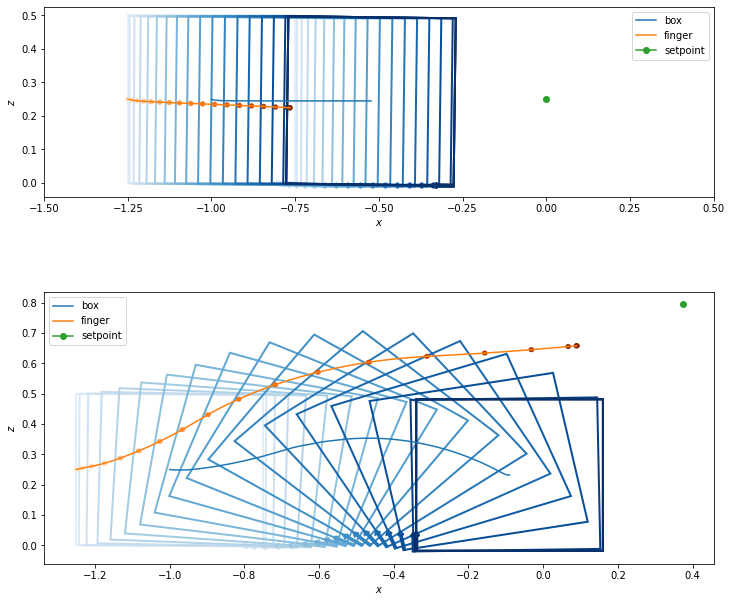

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12, 11))
## Initial
# Plot the center of mass trajectory
axs[0].plot(bs_trace_0[:, 0], bs_trace_0[:, 1], label="box")
axs[0].plot(fs_trace_0[:, 0], fs_trace_0[:, 1], label="finger")
axs[0].plot(waypoints_0[0], waypoints_0[1], "-o", label="setpoint")
axs[0].legend()

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace_0[i], alphas[i].item(), box_side_length, axs[0])
    make_finger_patches(fs_trace_0[i], alphas[i].item(), axs[0])

axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$z$")
axs[0].set_xlim([-1.5, 0.5])
axs[0].set_aspect("equal")

## Optimized!
# Plot the center of mass trajectory
axs[1].plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
axs[1].plot(fs_trace[:, 0], fs_trace[:, 1], label="finger")
axs[1].plot(waypoints[0], waypoints[1], "-o", label="setpoint")
axs[1].legend()

# Plot the box over time
n_steps_to_show = 20
i_to_show = jnp.linspace(0, N_steps, n_steps_to_show, dtype=int)
alphas = jnp.linspace(0.0, 1.0, N_steps)
box_side_length = 0.5
for i in i_to_show:
    make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, axs[1])
    make_finger_patches(fs_trace[i], alphas[i].item(), axs[1])

axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$z$")
axs[0].set_xlim([-1.5, 0.5])
axs[0].set_aspect("equal")

## Optimize two-finger control for box grasping

That seems like a good start. Can we learn to control two fingers?

In [39]:
def box_grasp_cost(finger_commands):
    """Compute the optimization cost for grasping and lifting the box
    
    args:
        finger_commands: (x1, z1, x2, z2) desired finger locations
    """
    bs_initial = jnp.array([0.0, 0.25, 0.0, 0.0, 0.0, 0.0])
    fs1_initial = jnp.array([-0.3, 0.25, 0.0, 0.0])
    fs2_initial = jnp.array([0.3, 0.25, 0.0, 0.0])
    finger_k = 40
    N_steps = 200
    fs1_desired_trace = jnp.zeros((N_steps, 2))
    fs1_desired_trace = fs1_desired_trace.at[:, 0].set(finger_commands[0])
    fs1_desired_trace = fs1_desired_trace.at[:, 1].set(finger_commands[1])
    fs2_desired_trace = jnp.zeros((N_steps, 2))
    fs2_desired_trace = fs2_desired_trace.at[:, 0].set(finger_commands[2])
    fs2_desired_trace = fs2_desired_trace.at[:, 1].set(finger_commands[3])

    # Simulate
    start = time.time()
    bs_trace, fs1_trace, fs2_trace = box_two_finger_simulate(
        bs_initial,
        fs1_initial,
        fs1_desired_trace,
        fs2_initial,
        fs2_desired_trace,
        finger_k,
        N_steps
    )
    
    # Make a cost with terminal cost telling us to lift to y = 1.0
    cost = (bs_trace[-1, 1] - 1.0) ** 2
    
    return cost

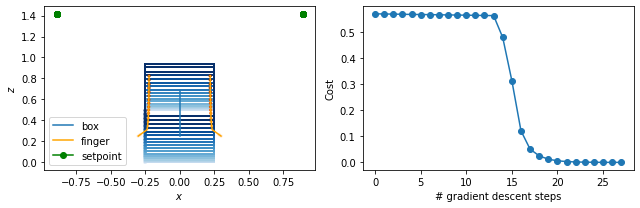

In [ ]:
# NOTE: This initialization will just make contact with the box.
waypoints_0 = jnp.array([-0.05, 0.25, 0.05, 0.25])
waypoints = waypoints_0.clone()

# Set up some details for a gradient-descent-based optimization
n_gd_steps = 100
learning_rate = 1e0

# Get the grad function
cost_grad_fn = jax.value_and_grad(box_grasp_cost)

# Set up some variables we'll reuse for simulations
bs_initial = jnp.array([0.0, 0.25, 0.0, 0.0, 0.0, 0.0])
fs1_initial = jnp.array([-0.3, 0.25, 0.0, 0.0])
fs2_initial = jnp.array([0.3, 0.25, 0.0, 0.0])
finger_k = 25
n_sim_steps = 200
fs1_desired_trace = jnp.zeros((N_steps, 2))
fs2_desired_trace = jnp.zeros((N_steps, 2))

# Run gradient descent
costs = []
waypoint_trace = []
prog_bar = range(n_gd_steps)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
try:
    for i in prog_bar:
        # Get the cost and gradient
        cost, cost_grad = cost_grad_fn(waypoints)
                
        # Save the cost and velocity
        costs.append(cost)
        waypoint_trace.append(waypoints)

        # Plot performance
        fs1_desired_trace = jnp.zeros((N_steps, 2))
        fs1_desired_trace = fs1_desired_trace.at[:, 0].add(waypoints[0])
        fs1_desired_trace = fs1_desired_trace.at[:, 1].add(waypoints[1])
        fs2_desired_trace = jnp.zeros((N_steps, 2))
        fs2_desired_trace = fs2_desired_trace.at[:, 0].add(waypoints[2])
        fs2_desired_trace = fs2_desired_trace.at[:, 1].add(waypoints[3])
        bs_trace, fs1_trace, fs2_trace = box_two_finger_simulate(
            bs_initial,
            fs1_initial,
            fs1_desired_trace,
            fs2_initial,
            fs2_desired_trace,
            finger_k,
            n_sim_steps,
        )
        plt.close(fig)
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        
        # Plot the center of mass trajectory
        axs[0].plot(bs_trace[:, 0], bs_trace[:, 1], label="box")
        axs[0].plot(fs1_trace[:, 0], fs1_trace[:, 1], color="orange", label="finger")
        axs[0].plot(fs2_trace[:, 0], fs2_trace[:, 1], color="orange")
        axs[0].plot(fs1_desired_trace[:, 0], fs1_desired_trace[:, 1], "-o", color="green", label="setpoint")
        axs[0].plot(fs2_desired_trace[:, 0], fs2_desired_trace[:, 1], "-o", color="green")
        axs[0].legend()

        # Plot the box over time
        n_steps_to_show = 20
        i_to_show = jnp.linspace(0, n_sim_steps, n_steps_to_show, dtype=int)
        alphas = jnp.linspace(0.0, 1.0, n_sim_steps)
        box_side_length = 0.5
        for i in i_to_show:
            make_box_patches(bs_trace[i], alphas[i].item(), box_side_length, axs[0])
            make_finger_patches(fs1_trace[i], alphas[i].item(), axs[0])
            make_finger_patches(fs2_trace[i], alphas[i].item(), axs[0])
        
        axs[0].set_xlabel(r"$x$")
        axs[0].set_ylabel(r"$z$")
        
        axs[1].plot(costs, "o-")
        axs[1].set_xlabel("# gradient descent steps")
        axs[1].set_ylabel("Cost")
        fig.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)

        # Make the gradient descent step
        waypoints = waypoints - learning_rate * cost_grad
except KeyboardInterrupt:
    pass